# 🤟 ASL (American Sign Language) 알파벳 분류기 (Linear Layer)

이 노트북은 **Fully Connected Layer (nn.Linear)**만을 사용하여 수화 알파벳(A-Z) 이미지를 분류하는 딥러닝 모델을 구현합니다.
CNN을 사용하지 않고, 기본적인 신경망 구조로 어느 정도의 성능을 낼 수 있는지 확인해 봅니다.

### 주요 특징
- **모델**: nn.Linear 층으로만 구성 (Input -> Hidden -> Output)
- **입력**: 28x28 이미지를 784차원 벡터로 평탄화(Flatten)
- **데이터**: Sign Language MNIST (CSV)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
from torchvision import transforms

# 한글 폰트 설정 (필요시)
import matplotlib as mpl
import matplotlib.font_manager as fm

# def set_korean_font():
#     for font_name in ["Malgun Gothic", "NanumGothic", "AppleGothic", "D2Coding"]:
#         try:
#             fm.findfont(font_name, fallback_to_default=False)
#             mpl.rcParams["font.family"] = font_name
#             mpl.rcParams["axes.unicode_minus"] = False
#             return font_name
#         except Exception:
#             continue
#     return None

# set_korean_font()

## 1. 하이퍼파라미터 설정

학습에 필요한 주요 파라미터를 설정합니다.

In [2]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
NUM_CLASSES = 26
INPUT_SIZE = 28 * 28  # 784
HIDDEN_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"사용 디바이스: {DEVICE}")

사용 디바이스: cuda


## 2. 데이터셋 클래스 정의

CSV 파일에서 데이터를 로드하고 전처리하는 커스텀 데이터셋 클래스입니다.

In [4]:
class ASLDataset(Dataset):
    """ASL 데이터셋 클래스"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            # 이미 Tensor가 아니라면 변환
            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(image).float()
            
            # Flatten이 안되어 있다면 (1, 28, 28) -> (784)
            # 하지만 여기서는 2D 이미지로 유지하고 모델 내부에서 Flatten 할 수도 있고,
            # 미리 Flatten 할 수도 있습니다. 
            # transforms.ToTensor()를 쓰면 (1, 28, 28)이 되므로 모델에서 Flatten 하는게 일반적입니다.
            pass

        label = torch.tensor(label, dtype=torch.long)
        return image, label

## 3. 데이터 로드 및 분할

데이터를 로드하고 Train(70%) / Valid(20%) / Test(10%)로 분할합니다.

In [5]:
# 데이터 전처리
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),  # (1, 28, 28)로 변환, 값은 0~1로 정규화됨
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# 데이터 로드
data_dir = "./data/asl_data"
train_csv = os.path.join(data_dir, "sign_mnist_train.csv")
valid_csv = os.path.join(data_dir, "sign_mnist_valid.csv")

if os.path.exists(train_csv) and os.path.exists(valid_csv):
    print("CSV 파일 로드 중...")
    df_train = pd.read_csv(train_csv)
    df_valid = pd.read_csv(valid_csv)
    
    # Train 데이터 처리
    train_labels = df_train.iloc[:, 0].values
    train_images = df_train.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
    
    # Valid 데이터 처리
    valid_labels = df_valid.iloc[:, 0].values
    valid_images = df_valid.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
    
    # 데이터셋 생성
    train_dataset = ASLDataset(train_images, train_labels, transform=train_transform)
    valid_dataset = ASLDataset(valid_images, valid_labels, transform=test_transform)
    
    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"데이터 로드 완료:")
    print(f"  Train: {len(train_dataset)}")
    print(f"  Valid: {len(valid_dataset)}")
else:
    print(f"파일을 찾을 수 없습니다: {train_csv} 또는 {valid_csv}")

CSV 파일 로드 중...
데이터 로드 완료:
  Train: 27455
  Valid: 7172


## 4. Linear 모델 정의

CNN을 사용하지 않고, `nn.Linear` 층으로만 구성된 모델을 정의합니다.
입력 이미지는 `view` 함수를 통해 1차원 벡터로 펼쳐집니다 (Flatten).

In [6]:
class ASL_Linear_Classifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=26):
        super(ASL_Linear_Classifier, self).__init__()
        # 입력층 -> 은닉층
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        # 은닉층 -> 출력층
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Flatten: (Batch, 1, 28, 28) -> (Batch, 784)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ASL_Linear_Classifier(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(DEVICE)
print(model)

ASL_Linear_Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=26, bias=True)
)


## 5. 학습 및 검증

모델을 학습하고 검증 데이터로 성능을 평가합니다.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

print("학습 시작...")

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Train Accuracy 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    
    # Valid
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_acc = 100 * correct / total
    
    valid_losses.append(avg_val_loss)
    valid_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Valid Loss: {avg_val_loss:.4f} | "
          f"Valid Acc: {val_acc:.2f}%")

print("학습 완료!")

학습 시작...
Epoch [1/20] Train Loss: 2.4276 | Train Acc: 27.06% | Valid Loss: 1.7777 | Valid Acc: 50.73%
Epoch [2/20] Train Loss: 1.6104 | Train Acc: 49.51% | Valid Loss: 1.4182 | Valid Acc: 58.09%
Epoch [3/20] Train Loss: 1.3034 | Train Acc: 58.41% | Valid Loss: 1.2588 | Valid Acc: 61.32%
Epoch [4/20] Train Loss: 1.1021 | Train Acc: 64.94% | Valid Loss: 1.1817 | Valid Acc: 63.58%
Epoch [5/20] Train Loss: 0.9576 | Train Acc: 69.53% | Valid Loss: 1.0343 | Valid Acc: 66.75%
Epoch [6/20] Train Loss: 0.8469 | Train Acc: 72.56% | Valid Loss: 0.9831 | Valid Acc: 69.80%
Epoch [7/20] Train Loss: 0.7593 | Train Acc: 75.49% | Valid Loss: 0.9476 | Valid Acc: 70.25%
Epoch [8/20] Train Loss: 0.6843 | Train Acc: 77.79% | Valid Loss: 0.8867 | Valid Acc: 71.54%
Epoch [9/20] Train Loss: 0.6075 | Train Acc: 80.58% | Valid Loss: 0.8911 | Valid Acc: 72.50%
Epoch [10/20] Train Loss: 0.5651 | Train Acc: 81.55% | Valid Loss: 0.8746 | Valid Acc: 74.30%
Epoch [11/20] Train Loss: 0.5163 | Train Acc: 83.14% | Valid

## 6. 결과 시각화

학습 과정에서의 손실과 정확도 변화를 그래프로 확인합니다.

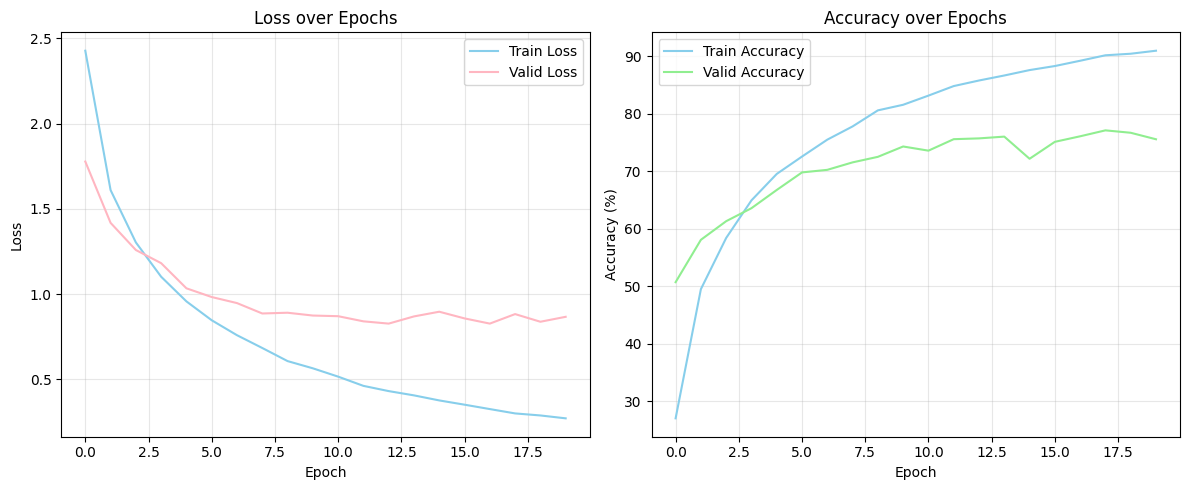

In [8]:
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#87CEEB')
plt.plot(valid_losses, label='Valid Loss', color='#FFB6C1')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='#87CEEB')
plt.plot(valid_accuracies, label='Valid Accuracy', color='#90EE90')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 사용자 이미지 예측

학습된 모델을 사용하여 외부 이미지(a.png, b.png)를 분류해 봅니다.

사용자 이미지 예측 결과:


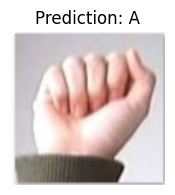

Image: ./data/asl_image/a.png -> Predicted: A


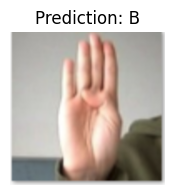

Image: ./data/asl_image/b.png -> Predicted: B


In [9]:
from PIL import Image

def predict_custom_image(image_path, model, device):
    if not os.path.exists(image_path):
        print(f"이미지 파일을 찾을 수 없습니다: {image_path}")
        return
        
    # 이미지 전처리
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
    
    try:
        image = Image.open(image_path)
        input_tensor = transform(image).unsqueeze(0).to(device) # (1, 1, 28, 28)
        
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            
        # 인덱스를 문자로 변환 (0='A', 1='B', ...)
        # 데이터셋의 라벨링 방식에 따라 다를 수 있지만, 일반적으로 0-25가 A-Z에 매핑됨 (J=9, Z=25 제외 여부 확인 필요)
        # 여기서는 단순하게 ASCII 코드로 변환
        predicted_char = chr(predicted.item() + ord('A'))
        
        plt.figure(figsize=(2, 2))
        plt.imshow(image, cmap='gray')
        plt.title(f"Prediction: {predicted_char}")
        plt.axis('off')
        plt.show()
        print(f"Image: {image_path} -> Predicted: {predicted_char}")
        
    except Exception as e:
        print(f"예측 중 오류 발생: {e}")

# 테스트할 이미지 경로
image_paths = ["./data/asl_image/a.png", "./data/asl_image/b.png"]

print("사용자 이미지 예측 결과:")
for path in image_paths:
    predict_custom_image(path, model, DEVICE)